Notebook originally by [@alekseynp](https://gist.github.com/alekseynp/41f70c509176cbff765e79ebe5edaa6a)

This notebooks illustrates how multiple sigmoid hidden neurons can model a 1D nonlinear function when being stacked together

In [1]:
import numpy as np
np.random.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mlp
mlp.style.use('classic')

In [2]:
from keras.models import Model
from keras.layers import Input, Dense
import keras.optimizers

Using Theano backend.


In [61]:
def relu(x):
    return np.maximum(0, x)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def activate(x):
    return sigmoid(x)

In [3]:
def get_model(num_hidden_units):
    model_input = Input(shape=(1,), dtype='float32', name='input')
    net = Dense(num_hidden_units, activation='sigmoid')(model_input)
    out = Dense(1, activation='linear')(net)

    model = Model(inputs=model_input, outputs=out)
    optimizer = keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, decay=0.0)
    model.compile(loss='mean_squared_error', optimizer=optimizer)    
    return model

In [4]:
def poly_generator(coeffs, batch_size=320):
    output_x = np.zeros((batch_size))
    output_y = np.zeros((batch_size))
       
    while True:
        output_x = np.random.uniform(-1.0, 1.0, batch_size)
        output_y = np.polynomial.polynomial.polyval(output_x, coeffs)
        yield output_x, output_y

In [5]:
def train_a_model(num_hidden_units, coeffs):
    model = get_model(num_hidden_units)
    generator = poly_generator(coeffs)
    model.fit_generator(generator, steps_per_epoch=5000, epochs=1, verbose=0)
    return model

In [6]:
def train_models(coeffs):
    models = []
    for num_hidden_units in np.arange(1, 10):
        print('{0}'.format(num_hidden_units), end=', ')
        mod = train_a_model(num_hidden_units, coeffs)
        models.append(mod)
    return models

In [7]:
def get_num_hidden_units(model):
    return model.layers[1].get_config()['units']

def plot_a_model(ax, model, coeffs):
    xs = np.arange(-1.0,1.0,0.01)
    ys = model.predict(xs).ravel()
    ys_true = np.polynomial.polynomial.polyval(xs, coeffs)

    ax.plot(xs, ys, label='Preds')
    ax.plot(xs, ys_true, label='Truth')

    # trying to highlight the kinks, maybe off by 1 or 2 positions, but that's fine
    delta = np.abs(ys[1:] - ys[:-1])
    ddelta = np.abs(delta[1:] - delta[:-1])
    num = get_num_hidden_units(model)
    idxes = np.argsort(ddelta)[-num:]
    ax.plot(xs[idxes], ys[idxes], 'o')

def plot_models(models, coeffs):
    assert len(models) == 9
    fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 10))

    for i, ax in enumerate(np.ravel(axarr)):
        print('{0}'.format(i + 1), end=', ')
        mod = models[i]
        num = get_num_hidden_units(mod)
        plot_a_model(ax, mod, coeffs)
        ax.set_title('# hidden units: {}'.format(num))
    plt.tight_layout()

# Experiments

### Experiment 1 
Target function:
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3$$

Model:
- Single layer neural network with between 1 and 9 hidden units

In [8]:
coeffs = [0.1, 0.2, 0.3, 0.4]

In [9]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 1min 1s, sys: 875 ms, total: 1min 2s
Wall time: 3min 48s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

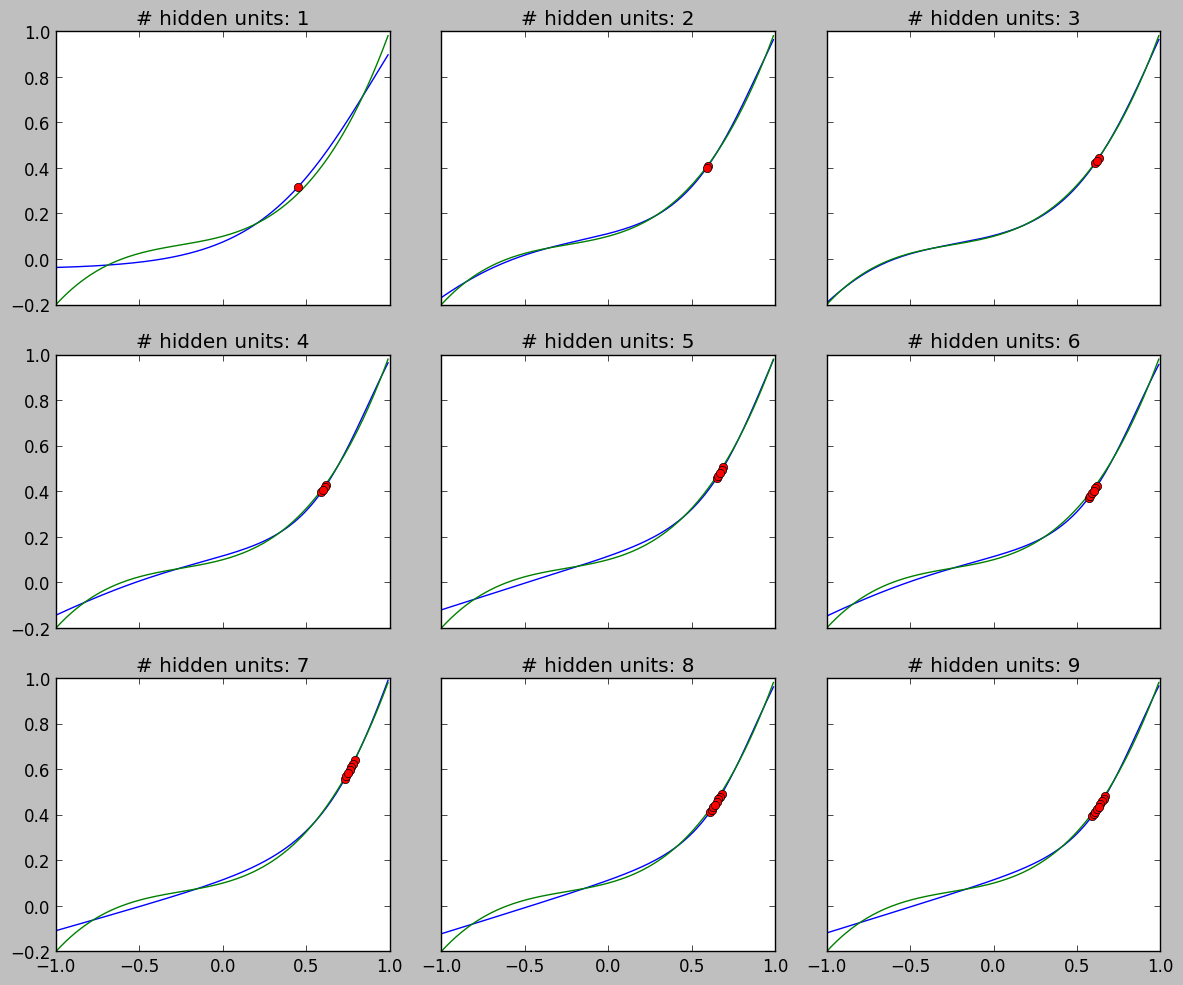

In [11]:
plot_models(models, coeffs)

circles highlight where the kinks are, it looks as the number of hidden neurons grow, the number of kinks increases, too, which hints a stacking effect of the ReLU hidden neurons.

### Experiment 2
Target function:
$$f(x) = x^2$$ 

Model:
- Single layer neural network with between 1 and 9 hidden units

In [12]:
coeffs = [0, 0, 1]

In [13]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 1min, sys: 775 ms, total: 1min 1s
Wall time: 3min 43s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

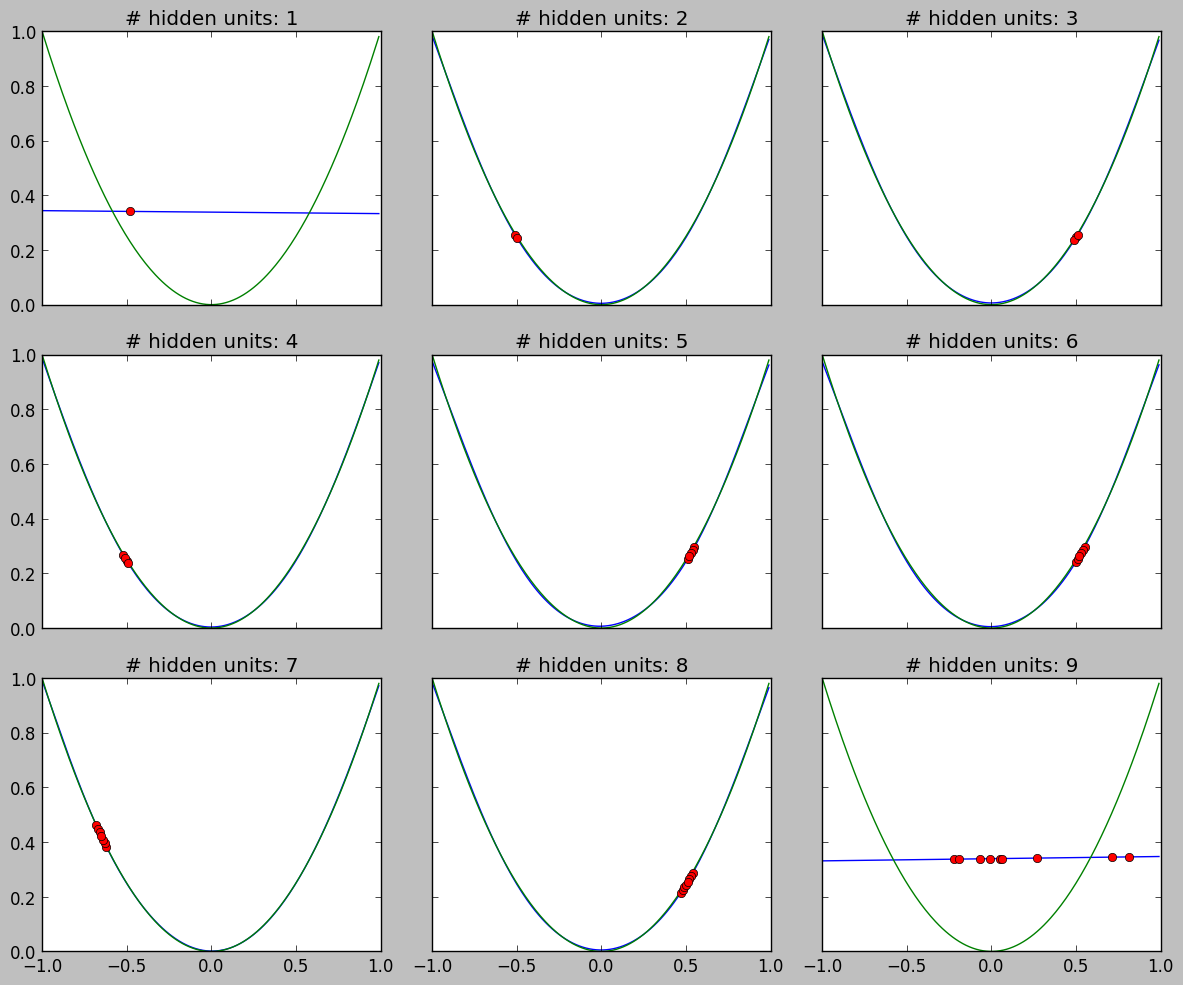

In [14]:
plot_models(models, coeffs)

It seems not necessarily always the more neurons, the better, sometimes it gets stuck

### Experiment 3
Target function:
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3 + 0.5x^4$$ 

Model:
- Single layer neural network with between 1 and 9 hidden units

In [15]:
coeffs = [0.1, 0.2, 0.3, 0.4, 0.5]

In [16]:
%time models = train_models(coeffs)

1, 2, 3, 4, 5, 6, 7, 8, 9, CPU times: user 1min 1s, sys: 684 ms, total: 1min 2s
Wall time: 3min 45s


1, 2, 3, 4, 5, 6, 7, 8, 9, 

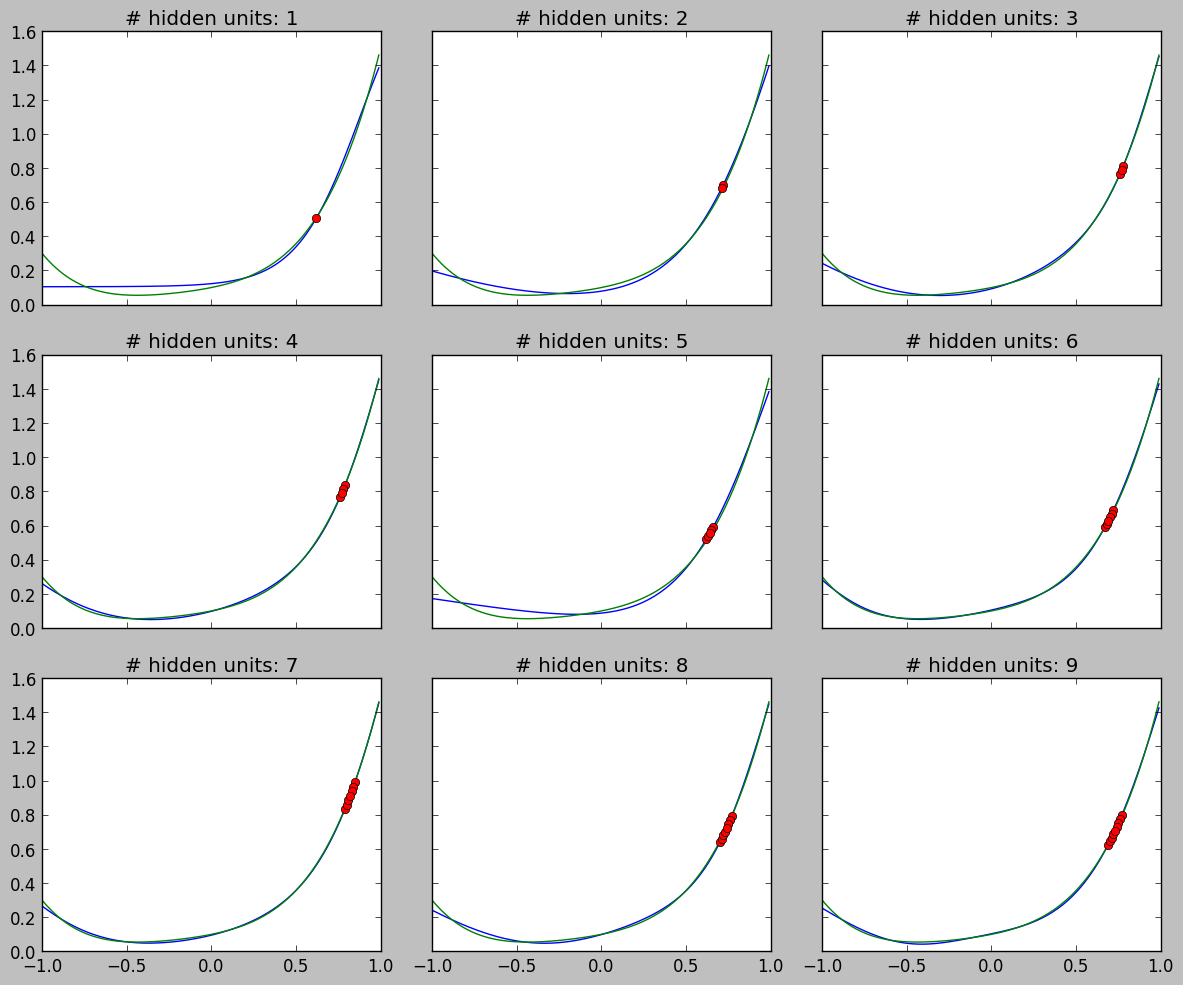

In [17]:
plot_models(models, coeffs)

# Dig a little deeper
$$f(x) = 0.1 + 0.2x + 0.3x^2 + 0.4x^3$$

In [49]:
coeffs = [0.1, 0.2, 0.3, 0.4]
num_hidden_units = 8
model = train_a_model(num_hidden_units, coeffs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
dense_61 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_62 (Dense)             (None, 1)                 9         
Total params: 25.0
Trainable params: 25.0
Non-trainable params: 0.0
_________________________________________________________________


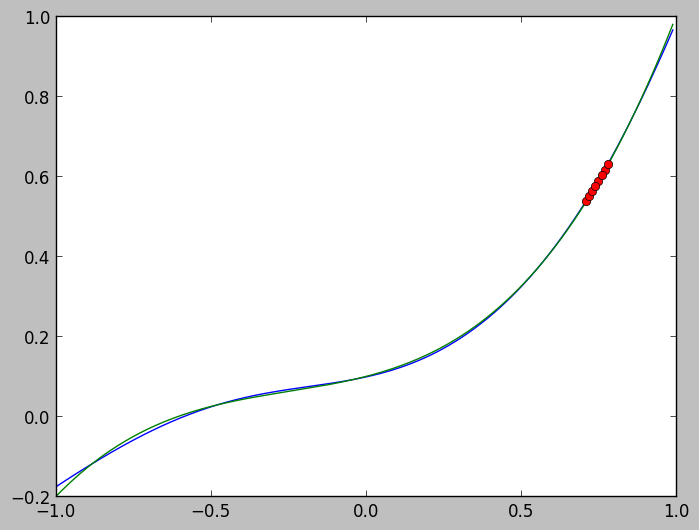

In [55]:
fig = plt.figure()
ax = plt.gca()
plot_a_model(ax, model, coeffs)

In [50]:
# train another model to illustrate local minima
model2 = train_a_model(num_hidden_units, coeffs)

In [51]:
hidden_weights = model.layers[1].get_weights()
output_weights = model.layers[2].get_weights()

In [52]:
hidden_weights

[array([[ 0.85860229,  3.64812922,  0.97750109,  3.15122414, -0.56171167,
         -0.98580265, -0.14342259, -0.99771148]], dtype=float32),
 array([ 0.06599269, -4.23441839,  0.33119664,  0.44910878, -0.09585279,
         2.75650239,  0.18161981, -0.49809003], dtype=float32)]

In [53]:
output_weights

[array([[ 1.09741735],
        [ 1.54474533],
        [ 1.24310696],
        [-0.86443394],
        [-0.2869702 ],
        [-0.44115987],
        [ 0.11408196],
        [-0.62860948]], dtype=float32), array([ 0.04082796], dtype=float32)]

# Plot each neuron output individually

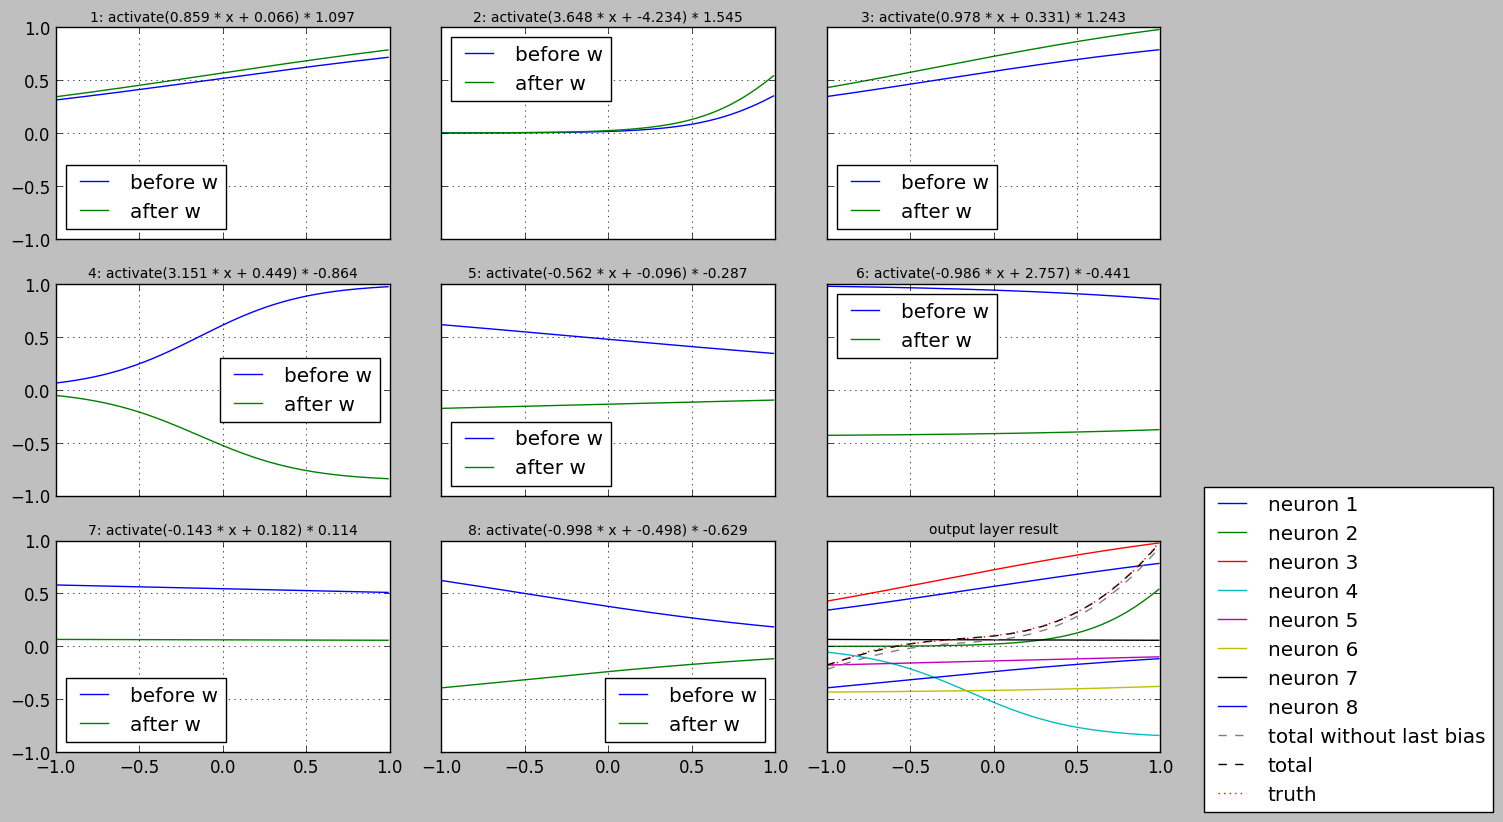

In [62]:
fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
activate_total = 0
activate_total_no_bias = 0
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    before = activate(hidden_w * xs + hidden_b) 
    after = before * output_w
    
    ax.plot(xs, before, label='before w')
    ax.plot(xs, after, label='after w')
    
    last_ax.plot(xs, after, label='neuron {0}'.format(i + 1))
    ax.set_title('{0}: activate({1:.3f} * x + {2:.3f}) * {3:.3f}'.format(i + 1, hidden_w, hidden_b, output_w),
                 fontsize=10)
    ax.grid()
    ax.legend(loc='best')

    activate_total += after

activate_total_no_bias = activate_total.copy()
output_b = output_weights[1][0]
activate_total += output_b

last_ax.plot(xs, activate_total_no_bias, '--', color='gray', label='total without last bias')
last_ax.plot(xs, activate_total, '--', color='black', label='total')

ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.grid()
last_ax.set_title('output layer result', fontsize=10)
last_ax.legend(loc="upper left", bbox_to_anchor=(1.1,1.3))

plt.tight_layout()

So weights and biases (from both 2nd and last layers) just change the slope and kink position of sigmoids. When they are all stacked together and summed up, interesting nonlinearity happens. A few neurons could be dead (useless) some times.

# Illustrate the stacking effects of sigmoid one by one

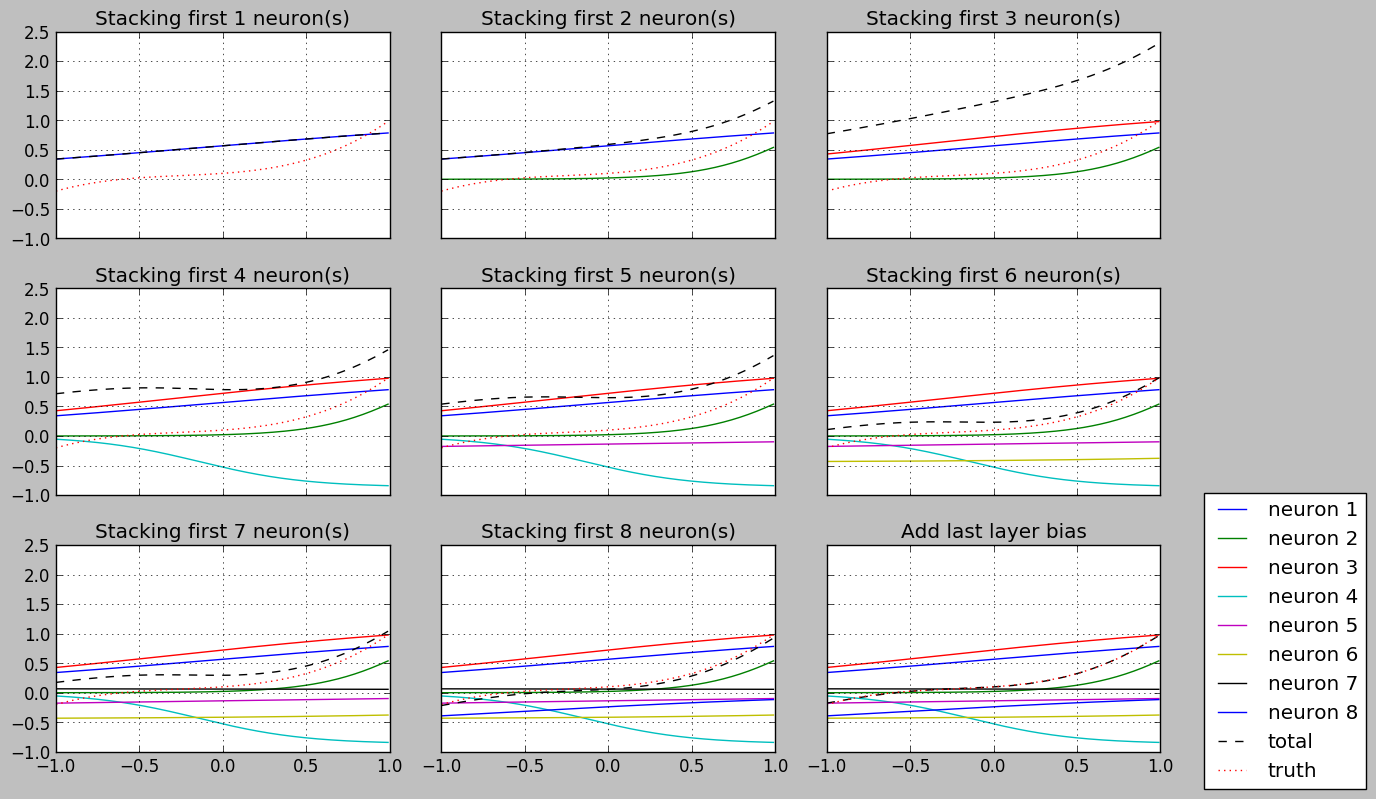

In [68]:
fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
activate_total = 0
activates = []
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    vals = activate(hidden_w * xs + hidden_b) * output_w
    activates.append((xs, vals, 'neuron {0}'.format(i + 1)))

    for _x, _y, _lab in activates:
        ax.plot(_x, _y, label=_lab)
    activate_total += vals   

    ax.plot(xs, activate_total, '--', color='black', label='total')
    ax.plot(xs, ys_true, ':', color='red', label='truth')
    ax.grid()
    ax.set_title('Stacking first {0} neuron(s)'.format(i + 1))

for _x, _y, _lab in activates:
    last_ax.plot(_x, _y, label=_lab)
output_b = output_weights[1][0]
activate_total += output_b
last_ax.plot(xs, activate_total, '--', color='black', label='total')
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.set_title('Add last layer bias')
last_ax.grid()
last_ax.legend(loc="upper left", bbox_to_anchor=(1.1,1.3))

plt.tight_layout()

# Illustrate difference/similarity between two trained models

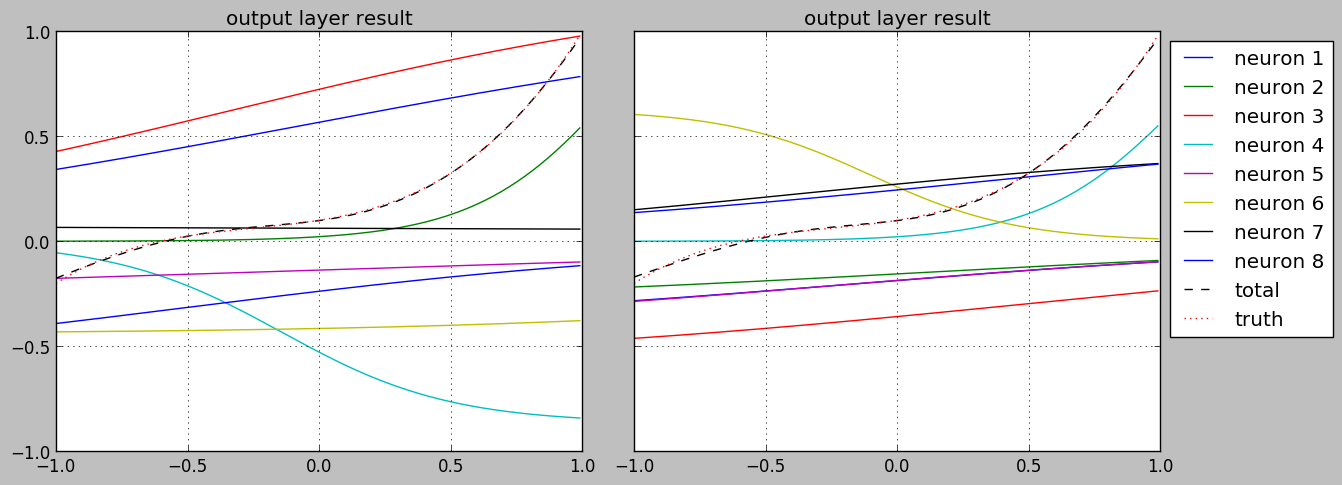

In [69]:
fig, axarr = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(12, 5))
axarr = axarr.ravel()

xs = np.arange(-1.0, 1.0, 0.01)
for k, (ax, mod) in enumerate(zip(axarr, [model, model2])):
    sigmoid_total = 0
    num_hu = get_num_hidden_units(mod)
    hidden_weights = mod.layers[1].get_weights()
    output_weights = mod.layers[2].get_weights()
    for i in range(num_hu):
        hidden_w = hidden_weights[0][0][i]
        hidden_b = hidden_weights[1][i]

        output_w = output_weights[0][i][0]
        vals = sigmoid(hidden_w * xs + hidden_b) * output_w
        ax.plot(xs, vals, label='neuron {0}'.format(i + 1))
        sigmoid_total += vals
    
    # There is only a single output bias value as there is only a single output neuron
    output_b = output_weights[1][0]
    sigmoid_total += output_b

    ax.plot(xs, sigmoid_total, '--', color='black', label='total')
    ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
    ax.plot(xs, ys_true, ':', color='red', label='truth')
    ax.grid()
    ax.set_title('output layer result')
    if k == 1:
        ax.legend(loc="upper left", bbox_to_anchor=(1, 1))

plt.tight_layout()

Seems the first model hits a worse local minimum.

#### So

1. At least in 1D, nonlinear functions can be approximated by stacking weighted sigmoid outputs given enough hidden neurons.

1. Kinks are results of overlapping 9 plots, assuming each line has one kink (i.e. non-linearity of sigmoid).

1. Repeating the experiments may produce hidden neurons with different weights and bias while their linear combination results in similar shape, which explains why multiple different NNs have similar performances (local minima!).

# Try another function

An interesting experiment above that might be simple enough to gain some inuition is the 4 neuron network attempting to fit $$f(x) = x^2$$

In [70]:
coeffs = [0, 0, 1]
num_hidden_units = 8
model = train_a_model(num_hidden_units, coeffs)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 1)                 0         
_________________________________________________________________
dense_65 (Dense)             (None, 8)                 16        
_________________________________________________________________
dense_66 (Dense)             (None, 1)                 9         
Total params: 25.0
Trainable params: 25.0
Non-trainable params: 0.0
_________________________________________________________________


### Plot target f(x) vs. neural network.

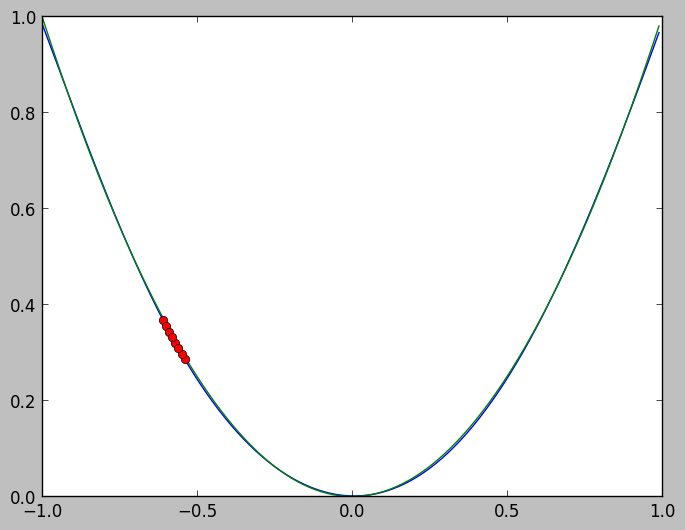

In [71]:
fig = plt.figure()
ax = plt.gca()
plot_a_model(ax, model, coeffs)

In [72]:
hidden_weights = model.layers[1].get_weights()
output_weights = model.layers[2].get_weights()

In [73]:
hidden_weights

[array([[ 2.20685816, -2.8562448 ,  2.69953227,  0.25307584,  0.32022494,
          0.22524545,  0.3679719 , -3.55152297]], dtype=float32),
 array([-2.17303038,  3.02417469,  0.49801743,  0.34941897,  0.26182917,
         0.37465027,  0.19359893, -3.45792317], dtype=float32)]

In [74]:
output_weights[0]

array([[ 1.27293766],
       [-1.40995204],
       [-0.63013339],
       [ 0.40139863],
       [ 0.52089375],
       [ 0.34827211],
       [ 0.86320806],
       [ 2.02021122]], dtype=float32)

### Plot each neuron individually as well as together

## Each suplot shows output from hidden sigmoid

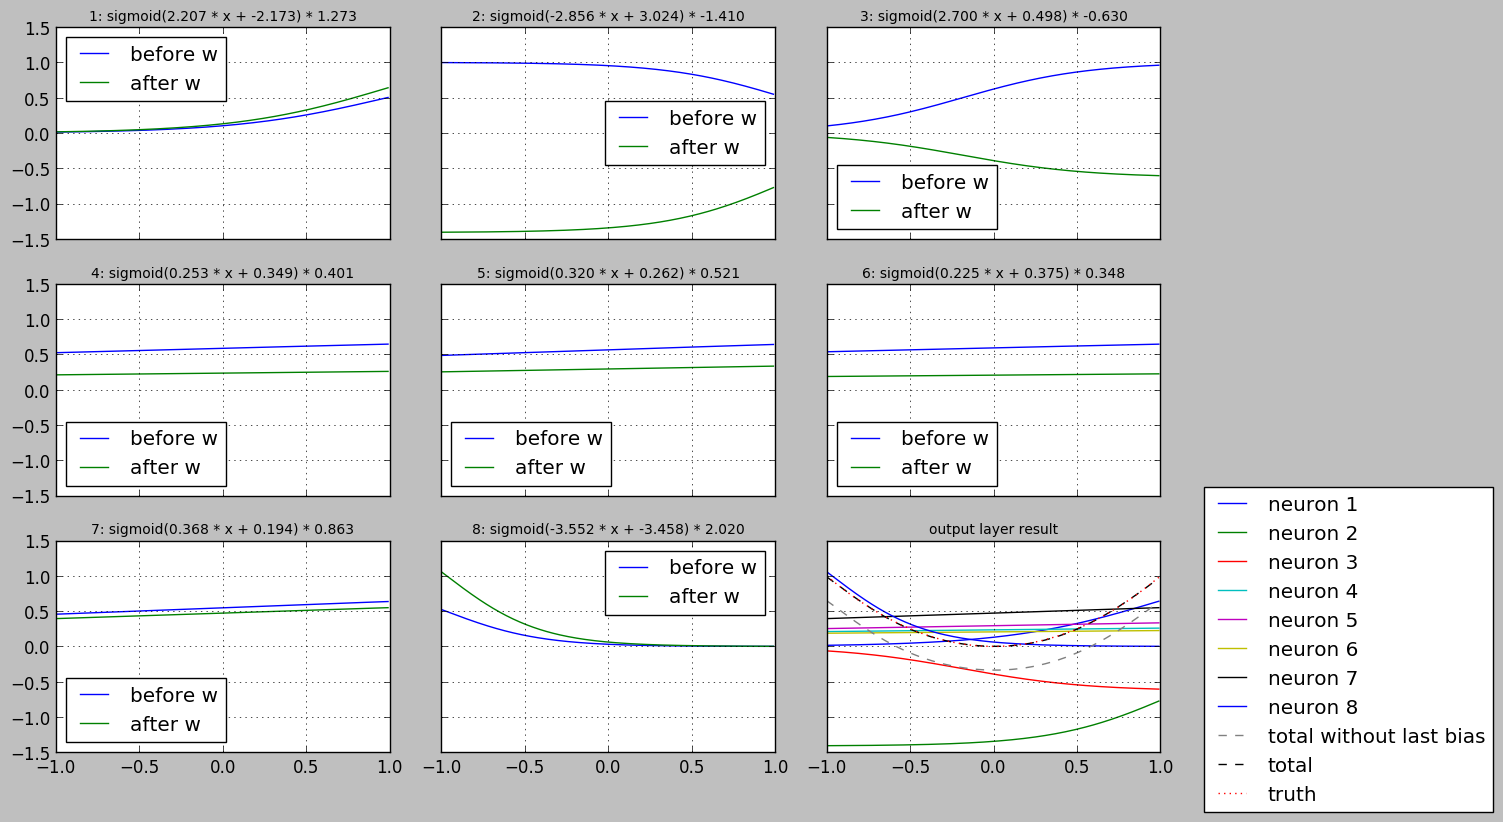

In [75]:
fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
sigmoid_total = 0
sigmoid_total_no_bias = 0
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    before = sigmoid(hidden_w * xs + hidden_b) 
    after = before * output_w
    
    ax.plot(xs, before, label='before w')
    ax.plot(xs, after, label='after w')
    
    last_ax.plot(xs, after, label='neuron {0}'.format(i + 1))
    ax.set_title('{0}: sigmoid({1:.3f} * x + {2:.3f}) * {3:.3f}'.format(i + 1, hidden_w, hidden_b, output_w),
                 fontsize=10)
    ax.grid()
    ax.legend(loc='best')

    sigmoid_total += after

sigmoid_total_no_bias = sigmoid_total.copy()
output_b = output_weights[1][0]
sigmoid_total += output_b

last_ax.plot(xs, sigmoid_total_no_bias, '--', color='gray', label='total without last bias')
last_ax.plot(xs, sigmoid_total, '--', color='black', label='total')

ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.grid()
last_ax.set_title('output layer result', fontsize=10)
last_ax.legend(loc="upper left", bbox_to_anchor=(1.1,1.3))

plt.tight_layout()

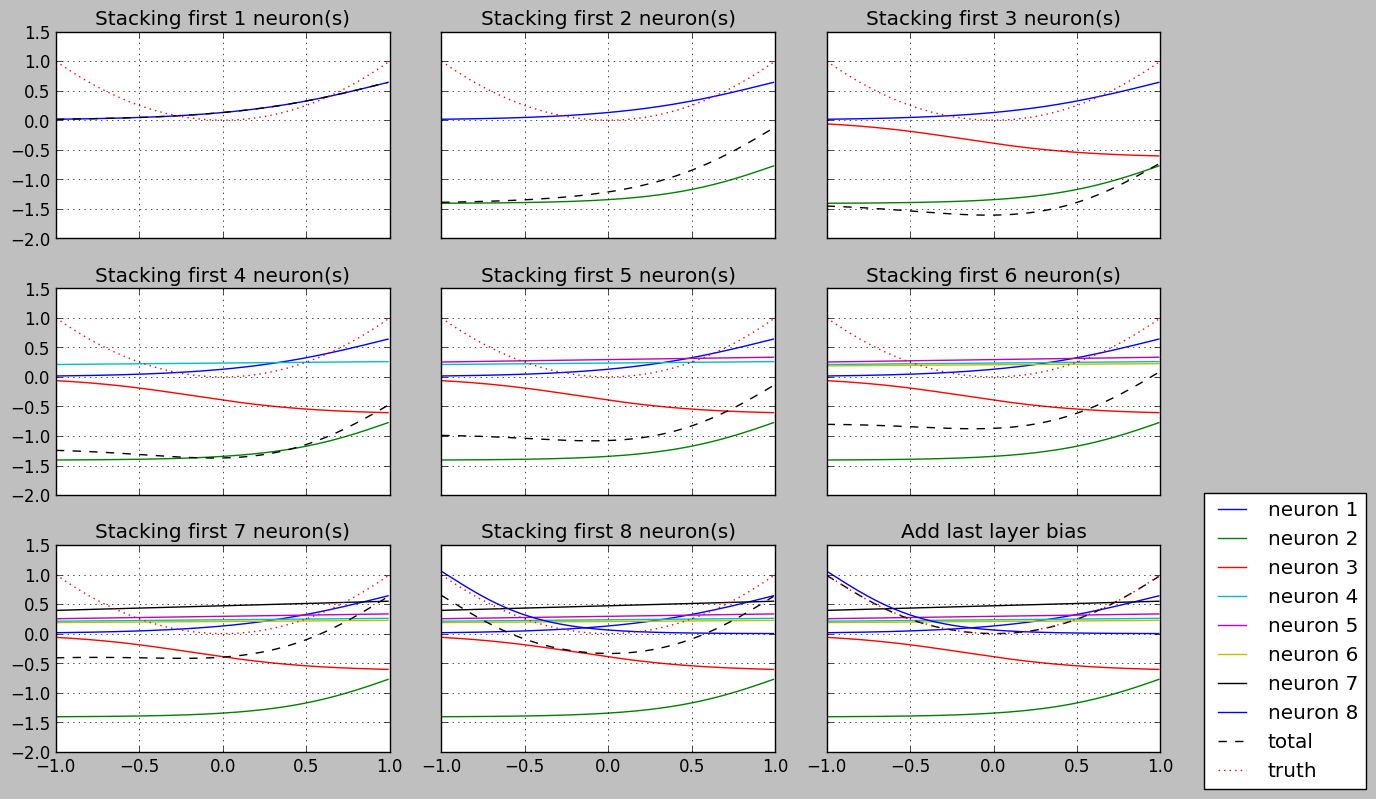

In [76]:
fig, axarr = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(12, 8))
axarr = axarr.ravel()
last_ax = axarr[-1]

xs = np.arange(-1.0, 1.0, 0.01)
ys_true = np.polynomial.polynomial.polyval(xs, coeffs)
activate_total = 0
activates = []
for i, ax in enumerate(axarr):
    if i >= num_hidden_units:
        continue
    hidden_w = float(hidden_weights[0][0][i])
    hidden_b = float(hidden_weights[1][i])

    output_w = output_weights[0][i][0]
    vals = activate(hidden_w * xs + hidden_b) * output_w
    activates.append((xs, vals, 'neuron {0}'.format(i + 1)))

    for _x, _y, _lab in activates:
        ax.plot(_x, _y, label=_lab)
    activate_total += vals   

    ax.plot(xs, activate_total, '--', color='black', label='total')
    ax.plot(xs, ys_true, ':', color='red', label='truth')
    ax.grid()
    ax.set_title('Stacking first {0} neuron(s)'.format(i + 1))

for _x, _y, _lab in activates:
    last_ax.plot(_x, _y, label=_lab)
output_b = output_weights[1][0]
activate_total += output_b
last_ax.plot(xs, activate_total, '--', color='black', label='total')
last_ax.plot(xs, ys_true, ':', color='red', label='truth')
last_ax.set_title('Add last layer bias')
last_ax.grid()
last_ax.legend(loc="upper left", bbox_to_anchor=(1.1,1.3))

plt.tight_layout()